## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *

### Data

In [5]:
path = untar_data(URLs.MNIST)

In [6]:
path.ls()

[PosixPath('/WORKSPACE/.fastai/data/mnist_png/training'),
 PosixPath('/WORKSPACE/.fastai/data/mnist_png/testing')]

In [7]:
il = ImageList.from_folder(path, convert_mode='L')

In [8]:
il.items[0]

PosixPath('/WORKSPACE/.fastai/data/mnist_png/training/8/55555.png')

In [9]:
defaults.cmap='binary'

In [10]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /WORKSPACE/.fastai/data/mnist_png

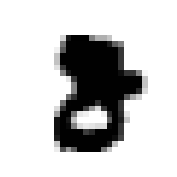

In [11]:
il[0].show()

In [13]:
sd = il.split_by_folder(train='training', valid='testing')

In [14]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /WORKSPACE/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /WORKSPACE/.fastai/data/mnist_png;

Test: None

In [15]:
(path/'training').ls()

[PosixPath('/WORKSPACE/.fastai/data/mnist_png/training/8'),
 PosixPath('/WORKSPACE/.fastai/data/mnist_png/training/9'),
 PosixPath('/WORKSPACE/.fastai/data/mnist_png/training/5'),
 PosixPath('/WORKSPACE/.fastai/data/mnist_png/training/1'),
 PosixPath('/WORKSPACE/.fastai/data/mnist_png/training/4'),
 PosixPath('/WORKSPACE/.fastai/data/mnist_png/training/6'),
 PosixPath('/WORKSPACE/.fastai/data/mnist_png/training/7'),
 PosixPath('/WORKSPACE/.fastai/data/mnist_png/training/2'),
 PosixPath('/WORKSPACE/.fastai/data/mnist_png/training/0'),
 PosixPath('/WORKSPACE/.fastai/data/mnist_png/training/3')]

In [16]:
ll = sd.label_from_folder()

In [17]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /WORKSPACE/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /WORKSPACE/.fastai/data/mnist_png;

Test: None

In [22]:
x,y = ll.train[0]

8 torch.Size([1, 28, 28])


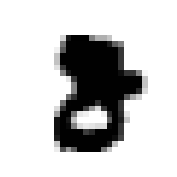

In [23]:
x.show()
print(y,x.shape)

In [24]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [26]:
ll = ll.transform(tfms)

In [27]:
bs = 128

In [28]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [29]:
x,y = data.train_ds[0]

8


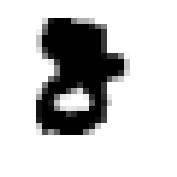

In [30]:
x.show()
print(y)

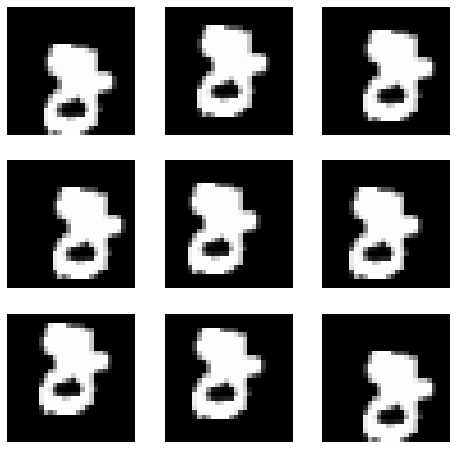

In [31]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [32]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

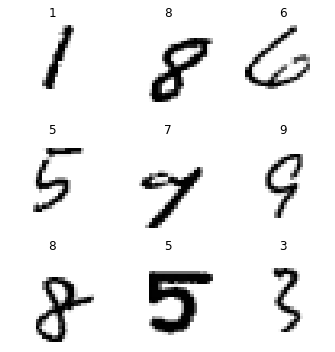

In [33]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [34]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [35]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [36]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [37]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [38]:
xb = xb.cuda()

In [39]:
model(xb).shape

torch.Size([128, 10])

In [44]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


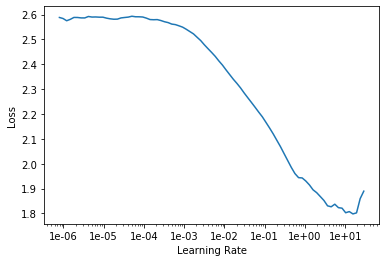

In [45]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.233983,0.231421,0.925300,00:06
1,0.135280,0.091266,0.970700,00:05
2,0.072797,0.043692,0.985600,00:05


### Refactor

In [50]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [51]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [52]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [53]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.237203,0.125666,0.962700,00:05
1,0.188067,0.217132,0.932100,00:05
2,0.155822,0.162861,0.951200,00:05
3,0.151602,0.151880,0.950700,00:05
4,0.131411,0.082485,0.973600,00:05
5,0.101665,0.086307,0.971300,00:05
6,0.080186,0.049313,0.985300,00:05
7,0.066407,0.040564,0.986800,00:05
8,0.053911,0.030214,0.990400,00:05
9,0.040965,0.026889,0.991600,00:05


### Resnet-ish

In [54]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [55]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [56]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [57]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [58]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [59]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


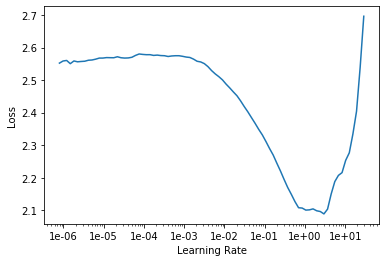

In [60]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(12, max_lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.668039,0.451619,0.945400,00:08
1,0.179994,0.149180,0.960400,00:08
2,0.116156,0.152332,0.949500,00:08
3,0.085126,0.057429,0.984400,00:08
4,0.066934,0.057509,0.981400,00:08
5,0.056006,0.037458,0.988200,00:08
6,0.052555,0.031268,0.990200,00:09
7,0.034370,0.024724,0.992200,00:08
8,0.031555,0.019145,0.994300,00:08
9,0.024727,0.019178,0.993400,00:08


In [ ]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.248807,0.121582,0.972800
2,0.120927,0.360583,0.890300
3,0.104013,0.074916,0.977800
4,0.081181,0.065717,0.980000
5,0.068514,0.096448,0.967200
6,0.061274,0.087955,0.971800
7,0.051673,0.033911,0.989400
8,0.048090,0.033234,0.988800
9,0.039095,0.024638,0.992400
10,0.023670,0.021215,0.993400


In [62]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

## fin